In [1]:
import logging
# set seed
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
import utils as ut
import experiment as ex
from evaluation import *
from sklearn.metrics import mean_squared_error
from torch.utils.tensorboard import SummaryWriter
import torch
import random
#define fixed_hyperparams and create a config gen
from configurations import RandomConfigGen, Configuration
from torch import nn
from deep_net import RandomNet
from experiment import run_experiment
import regex as re
from pathlib import *
from sk_models import CustomWrapper

seed = 1
torch.manual_seed(seed)
random.seed(seed + 1)
np.random.seed(seed + 2)
random_state = np.random.RandomState(seed)
import gc
torch.cuda.empty_cache()
gc.collect()

print(f"GPU detected is {torch.cuda.get_device_name(0)}")

GPU detected is GeForce GTX 970


In [2]:
#setup input and outpu t formats, load data

#we need to set parametesr
file_name = "mango_684_990.csv"#fitlered=513-1050 #"mango_684_990.csv" #"mango_729_975.csv" 
id_cols =['Set','Season','Region','Date','Type','Cultivar','Pop','Temp',"FruitID"]#
output_cols = ['DM']

data_path = Path('D:/workspace/lazydeep/data/soil_data/')
log_path = Path("D:/workspace/lazydeep/experiments/1.01") #1.01/")
if not log_path.exists():
    log_path.mkdir()

data_file = data_path / file_name
log_dir = log_path / re.sub(r'\.(?=csv$)[^.]+$', '',file_name)
if not log_dir.exists():
    log_dir.mkdir()
print(f"Output directory is {log_dir}")

Output directory is D:\workspace\lazydeep\experiments\1.01\mango_684_990


In [3]:
data = pd.read_csv(data_file)
nrow, ncol = data.shape
n_features = ncol - 1-len(id_cols)
n_comps = [i for i in range(1,min(101,n_features))]
data = ut.sample_data(data,random_state)
dataset = ut.TabularDataset(data,id_cols = id_cols, cat_cols=None, output_cols=output_cols, ignore_cols= None)
eval = MangoesSplitter(preprocessing=None,tensorboard=None,time=True,random_state=random_state)
print(f"Dataset shape is {data.shape}")

Dataset shape is (11691, 113)


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [4]:
# set logging, in this case the root logger
ut.setup_logger(logger_name="log",file_name=log_dir/"log.txt")
ut.setup_logger(logger_name="test_log",file_name=log_dir/"test_log.txt")
ut.setup_logger(logger_name="summary",file_name=log_dir/"summary.txt")
tb = SummaryWriter(log_dir/"tb")
summary_logger = logging.getLogger("summary")
#step 1, run pls, set up pls - that runs best
pls_models = {i:CustomWrapper(PLSRegression(n_components=i)) for i in n_comps}

pls_scheme = SKLearnScheme(logger="log")
scores_pls, preds_pls, model_states_pls , train_time_pls, test_time_pls = eval.evaluate(pls_models,dataset,pls_scheme,logger_name="log")
summary_logger.info(f"Train times: {train_time_pls}")
summary_logger.info(f"Test times: {test_time_pls}")
from collections import defaultdict
summary_logger.info(f"Scores: {scores_pls}")
for key,value in flip_dicts(scores_pls).items():
    summary_logger.info(f"{key}: {value}")

selected_comps =  min(scores_pls["MSE"],key=scores_pls["MSE"].get)
summary_logger.info(f"Selected pls preprocessing with {selected_comps} components")


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of 1:5.2855,2:5.2288,3:5.0751,4:4.7223,5:3.7266,6:2.7844,7:2.5206,8:1.2334,9:0.9928,10:0.8635,11:0.8248,12:0.7986,13:0.7882,14:0.773,15:0.7589,16:0.7496,17:0.7459,18:0.7411,19:0.7336,20:0.7298,21:0.7271,22:0.7241,23:0.7216,24:0.7198,25:0.7168,26:0.7143,27:0.7122,28:0.7104,29:0.7081,30:0.7073,31:0.7059,32:0.7048,33:0.7043,34:0.7037,35:0.7028,36:0.7022,37:0.7017,38:0.7013,39:0.7011,40:0.7009,41:0.7008,42:0.7006,43:0.7005,44:0.7004,45:0.7004,46:0.7003,47:0.7002,48:0.7002,49:0.7002,50:0.7001,51:0.7001,52:0.7001,53:0.7,54:0.7,55:0.6999,56:0.6999,57:0.6998,58:0.6997,59:0.6997,60:0.6996,61:0.6996,62:0.6995,63:0.6995,64:0.6995,65:0.6995,66:0.6995,67:0.6995,68:0.6994,69:0.6994,70:0.6994,71:0.6994,72:0.6994,73:0.6994,74:0.6994,75:0.6994,76:0.6994,77:0.6993,78:0.6993,79:0.6993,80:0.6993,81:0.6993,82:0.6

In [5]:
eval.preprocessing= Preprocess_PLS(n_components=selected_comps)

### Training the deep learners
The following cells setup our models and run a train-test evaluation.

In [6]:
n_models = 100
epochs = 100
bs = 32
fixed_hyperparams = {'bs': bs,'loss': nn.MSELoss(),'epochs': epochs}
device = "cpu" #torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#setup models
config_gen = RandomConfigGen(lr= (0,1),
                             allow_increase_size=False,
                             n_features=selected_comps,
                             opt=[torch.optim.SGD,
                                  torch.optim.Adam],
                             lr_update = [None,
                                          torch.optim.lr_scheduler.ReduceLROnPlateau,
                                          torch.optim.lr_scheduler.ExponentialLR,
                                          torch.optim.lr_scheduler.CosineAnnealingLR],
                            dropout = [True,False],
                            batch_norm = [True,False])
configs = {f"random_{i}":config_gen.sample() for i in range(n_models)}
config_gen.save(log_dir/'config_gen.txt')

deep_models = {name:RandomNet(input_size=selected_comps,
                             n_layers=config.n_layers,
                             act_function=config.act_function,
                             n_features = config.n_features,
                             dropout=config.dropout,
                             batch_norm=config.batch_norm,
                             device=device,dtype=torch.float)
              for name, config in configs.items()}

ex.write_summary_head(seed,fixed_hyperparams)
ex.save_models(deep_models,configs,log_dir)
start = datetime.datetime.now()
deep_scheme = DeepScheme(configs,fixed_hyperparams=fixed_hyperparams,logger="log",device=device,adaptive_lr=True)
scores_deep, preds_deep, model_states_deep , train_time_deep, test_time_deep = eval.evaluate(deep_models,dataset,deep_scheme,logger_name="log")


summary_logger.info(f"Train times: {train_time_deep}")
summary_logger.info(f"Test times: {test_time_deep}")
from collections import defaultdict

Starting Experiment'
Seed: 1'
bs: 32'
epochs: 100'
--------------------'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Training extractors on 5879 instances, validating on 1929 instances, for 100 epochs'

--- EPOCH 0---'
Extractor Train Losses are random_0:nan(-0.091585),random_1:nan(-0.606802),random_2:45.3776(-0.901208),random_3:230275463251927.28(-0.56051),random_4:nan(-0.510167),random_5:10.5038(-0.361886),random_6:258279932.5724(-0.279102),random_7:8.6927(-0.567705),random_8:2936.2643(-0.772984),random_9:nan(-0.488906),random_10:nan(-0.058759),random_11:14.0193(-0.244832),random_12:11.0298(-0.360218),random_13:nan(-0.729424),random_14:7.6577(-0.385566),random_15:nan(-0.286027),random_16:11.2347(-0.862446),random_17:nan(-0.447822),random_18:7.7142(-0.259096),random_19:9.2947(-0.033556),random_20:nan(-0.232474),random_21:13.6416(-0.684561),random_22:nan(-0.111175),random_23:nan

In [12]:
for model, state_dict in model_states_ls_final.items():
     torch.save(state_dict.state(), log_dir / "models" / f"{model}" / f"_final")


In [7]:
ex.save_results(model_states_deep, preds_deep,configs, scores_deep, log_dir,tb,prefix="")

#summary_logger.info(f"Scores: {scores_deep}")
#for key,value in flip_dicts(scores_deep).items():
#    summary_logger.info(f"{key}: {value}")

end = datetime.datetime.now()
diff = end - start
ex.write_summary(diff, deep_models, scores_deep,prefix="")
ex.save_pred_plots(preds_deep, deep_models,log_dir)


Experiments took 7:46:51.806646'
Finished Random Deep Search'
---Loss results---'
0 - random_59 - fold_0:0.4222,fold_1:0.438,fold_2:0.3977,fold_3:0.4505,fold_4:0.4563,MSE:0.4331,R2:0.9287'
1 - random_21 - fold_0:0.4698,fold_1:0.4914,fold_2:0.4436,fold_3:0.5079,fold_4:0.486,MSE:0.48,R2:0.921'
2 - random_82 - fold_0:0.4797,fold_1:0.4965,fold_2:0.4374,fold_3:0.517,fold_4:0.4866,MSE:0.4837,R2:0.9203'
3 - random_5 - fold_0:0.4567,fold_1:0.4861,fold_2:0.4654,fold_3:0.5313,fold_4:0.526,MSE:0.4934,R2:0.9188'
4 - random_77 - fold_0:0.4923,fold_1:0.5064,fold_2:0.449,fold_3:0.5417,fold_4:0.5385,MSE:0.5058,R2:0.9167'
5 - random_8 - fold_0:0.5057,fold_1:0.5847,fold_2:0.4532,fold_3:0.6014,fold_4:0.4718,MSE:0.524,R2:0.9137'
6 - random_7 - fold_0:0.5023,fold_1:0.5104,fold_2:0.5093,fold_3:0.5631,fold_4:0.5415,MSE:0.5255,R2:0.9135'
7 - random_26 - fold_0:0.5295,fold_1:0.5177,fold_2:0.4846,fold_3:0.5489,fold_4:0.5524,MSE:0.5267,R2:0.9133'
8 - random_42 - fold_0:0.5261,fold_1:0.5671,fold_2:0.4731,fold_3:0

### Plotting deep results as a function of number of features

In [8]:
scores_df = pd.DataFrame(scores_deep)
scores_df.to_csv(log_dir / f"scores.csv", index=False)


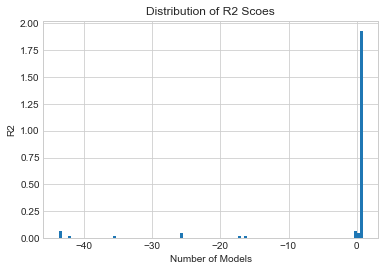

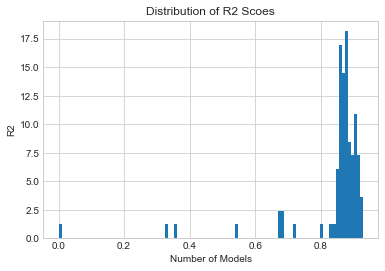

In [9]:
from matplotlib import pyplot as plt
if True:
    # plot deep results as a function of number of features

    n_features_dict = {name:config.n_features for name,config in configs.items()}
    to_plot = pd.DataFrame([[name, scores_deep["R2"][name],n_features_dict[name]] for name in scores_deep["R2"].keys()]
                           ,columns = ["name","score","n_features"])

    fig, ax = plt.subplots()
    ax.hist(to_plot["score"],bins=100,density=True)
    #ax.set_xscale('log')
    #ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
    ax.set_xlabel("Number of Models")
    ax.set_ylabel("R2")
    ax.set_title("Distribution of R2 Scoes")
    plt.savefig(log_dir / f"dist_plot.png",bbox_inches='tight')
    #plt.savefig(log_dir / f"pp_deep_pls_compressed.png",bbox_inches='tight')

    n_features_dict = {name:config.n_features for name,config in configs.items()}
    to_plot = pd.DataFrame([[name, scores_deep["R2"][name],n_features_dict[name]] for name in scores_deep["R2"].keys()]
                           ,columns = ["name","score","n_features"])
    to_plot = to_plot[to_plot["score"]>=0]

    fig, ax = plt.subplots()
    ax.hist(to_plot["score"],bins=100,density=True)
    #ax.set_xscale('log')
    #ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
    ax.set_xlabel("Number of Models")
    ax.set_ylabel("R2")
    ax.set_title("Distribution of R2 Scoes")
    plt.savefig(log_dir / f"dist_plot_compressed.png",bbox_inches='tight')
    #plt.savefig(log_dir / f"pp_deep_pls_compressed.png",bbox_inches='tight')
    pass

    #plot


In [10]:
summary_logger.info("------------------\n Top 5 performance on Test Set")
summary_logger.info(f"Index - Model - Val MSE - Val R2 - Test MSE - Test R2")
for i,key in enumerate(sorted(scores_deep['MSE'],key=scores_deep['MSE'].get)):
    if i <5:
        summary_logger.info(f"{i} - {key} - {scores_deep['MSE'][key]} -{scores_deep['R2'][key]} - {scores_deep['MSE'][key]} - {scores_final['MSE'][key]} - {scores_final['R2'][key]}")

------------------
 Top 5 performance on Test Set'
Index - Model - Val MSE - Val R2 - Test MSE - Test R2'
0 - random_59 - 0.43306340817755357 -0.9286805557796618 - 0.43306340817755357 - 0.42170509596475647 - 0.9280908284483946'
1 - random_21 - 0.4799505873708412 -0.9209588977083947 - 0.4799505873708412 - 0.4657102763559929 - 0.9205870631484439'
2 - random_82 - 0.48366034364942684 -0.9203479530961609 - 0.48366034364942684 - 0.4578542216768783 - 0.9219266779386015'
3 - random_5 - 0.49335999782943973 -0.9187505566590914 - 0.49335999782943973 - 0.4838474046384497 - 0.9174943192342806'
4 - random_77 - 0.505792788032493 -0.9167030512115144 - 0.505792788032493 - 0.45826492635115224 - 0.9218566445594415'
